# Micrograph Classification

## Necessary Imports

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from sklearn import svm
import time
import multiprocessing as mp

Using TensorFlow backend.


In [2]:
raw_input_df = pd.read_csv('Datasets\Assignment 2\micrograph.csv')
display(raw_input_df.head())

# selecting only spheroidite, network and pearlite data
labels = set(['spheroidite', 'network', 'pearlite'])
input_df = raw_input_df[[x in labels for x in raw_input_df['primary_microconstituent']] ]
display(input_df.head())

,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent
0,1,micrograph1.tif,5.0,um,129,4910x,SE,42.0,2,pearlite
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18.0,2,spheroidite
2,4,micrograph4.tif,10.0,um,129,NaN,SE,35.0,2,pearlite+spheroidite
3,5,micrograph5.tif,5.0,um,129,4910X,SE,10.0,2,pearlite
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29.0,2,spheroidite


,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent
0,1,micrograph1.tif,5.0,um,129,4910x,SE,42.0,2,pearlite
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18.0,2,spheroidite
3,5,micrograph5.tif,5.0,um,129,4910X,SE,10.0,2,pearlite
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29.0,2,spheroidite
6,8,micrograph8.tif,100.0,um,103,NaN,SE,31.0,2,network


## Train/Test split

In [3]:
train_spher_df = input_df[input_df['primary_microconstituent']=='spheroidite'].iloc[:100, :]
train_net_df = input_df[input_df['primary_microconstituent']=='network'].iloc[:100, :]
train_pear_df = input_df[input_df['primary_microconstituent']=='pearlite'].iloc[:100, :]

assert train_spher_df.shape[0] == 100
assert train_net_df.shape[0] == 100
assert train_pear_df.shape[0] == 100

assert pd.Series(train_spher_df['primary_microconstituent']=='spheroidite').all()
assert pd.Series(train_net_df['primary_microconstituent']=='network').all()
assert pd.Series(train_pear_df['primary_microconstituent']=='pearlite').all()

#display(train_spher_df.head())
#display(train_net)
#display(train_pear)

test_spher_df = input_df[input_df['primary_microconstituent']=='spheroidite'].iloc[100:, :]
test_net_df = input_df[input_df['primary_microconstituent']=='network'].iloc[100:, :]
test_pear_df = input_df[input_df['primary_microconstituent']=='pearlite'].iloc[100:, :]

#print(test_spher.shape)
#print(test_net.shape)
#print(test_pear.shape)

train_df = pd.concat([train_spher_df, train_net_df, train_pear_df])
test_df = pd.concat([test_spher_df, test_net_df, test_pear_df])

display(train_df.head())
print(train_df.shape)
print(test_df.shape)


,micrograph_id,path,micron_bar,micron_bar_units,micron_bar_px,magnification,detector,sample_key,contributor_key,primary_microconstituent
1,2,micrograph2.tif,10.0,um,103,1964X,SE,18.0,2,spheroidite
4,6,micrograph6.tif,20.0,um,124,1178X,SE,29.0,2,spheroidite
8,10,micrograph10.png,10.0,um,103,1964X,SE,39.0,2,spheroidite
9,11,micrograph11.tif,10.0,um,103,1964X,SE,18.0,2,spheroidite
20,29,micrograph29.tif,20.0,um,154,1473X,SE,35.0,2,spheroidite


(300, 10)
(410, 10)


#### Non-linear SVM with Radial Basis Function kernel

In [4]:
clf = svm.SVC(kernel='rbf', gamma='auto')

### Utility function to write multi-dimensional arrays to txt file

In [5]:
def md_save(file, x):
    with open(file, 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write('# Array shape: {0}\n'.format(x.shape))

        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in x:

            # The formatting string indicates that I'm writing out
            # the values in left-justified columns 7 characters in width
            # with 2 decimal places.  
            np.savetxt(outfile, data_slice, fmt='%-7.2f')

            # Writing out a break to indicate different slices...
            outfile.write('# New slice\n')


### Pre-processing Images

In [6]:
img_dir = 'Datasets\Assignment 2\micrograph\\'
img = image.load_img(img_dir + 'micrograph1.tif')
print('Image mode: ', img.mode)
x = image.img_to_array(img)

from matplotlib import pyplot as plt



print('Input Image size: ', x.shape)

x = x[0:484, :, :]
print('Cropped Image size: ', x.shape)

#md_save('before.txt', x)

plt.imshow(np.asarray(img)[0:484,:,:])
plt.show()

x = np.expand_dims(x, axis=0)
print('Adding dimension: ', x.shape)

# to see what the pre_process does:
#print(x)
#md_save('after.txt', x[0])
#img2 = image.array_to_img(x[0])
#img2.show()


x = preprocess_input(x)

plt.imshow(x[0])
plt.show()

Image mode:  RGB
Input Image size:  (522, 645, 3)
Cropped Image size:  (484, 645, 3)


<Figure size 640x480 with 1 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adding dimension:  (1, 484, 645, 3)


<Figure size 640x480 with 1 Axes>

In [12]:
x.shape

(1, 484, 645, 3)

Image mode:  RGB
Input Image size:  (522, 645, 3)
Cropped Image size:  (484, 645, 3)


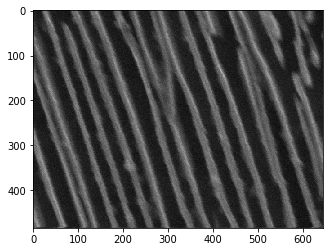

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adding dimension:  (1, 484, 645, 3)
(484, 645, 3)


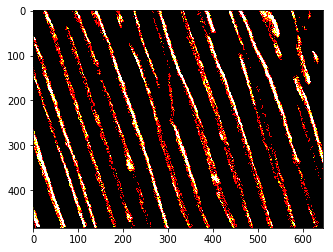

In [13]:
img_dir = 'Datasets\Assignment 2\micrograph\\'
img = image.load_img(img_dir + 'micrograph1467.tif')
print('Image mode: ', img.mode)
x = image.img_to_array(img)

from matplotlib import pyplot as plt



print('Input Image size: ', x.shape)

x = x[0:484, :, :]
print('Cropped Image size: ', x.shape)

#md_save('before.txt', x)

plt.imshow(np.asarray(img)[0:484,:,:])
plt.show()

x = np.expand_dims(x, axis=0)
print('Adding dimension: ', x.shape)

# to see what the pre_process does:
#print(x)
#md_save('after.txt', x[0])
#img2 = image.array_to_img(x[0])
#img2.show()


x = preprocess_input(x)
print(x[0].shape)
plt.imshow(x[0])
plt.show()

In [6]:
def preprocess_images(img_dir, filename_list):
    img_list = [image.load_img(img_dir + img_file) for img_file in filename_list]

    x_list = [image.img_to_array(img) for img in img_list]

    from matplotlib import pyplot as plt

    #Cropping out subtitles
    x_list = np.array([x[0:484, :, :] for x in x_list])
    #adding dummy dimension to each image in x_list (to access after expansion, use x_list[0 to n][0][j][k])
    x_list = np.array([np.expand_dims(x, axis=0) for x in x_list])

    #plt.imshow(np.asarray(img_list[300-1])[0:484,:,:])
    #plt.show()

    x_list = np.array([preprocess_input(x) for x in x_list])

    #print(x_list.shape)

    #plt.imshow(x_list[300-1][0])
    #plt.show()
    
    return x_list

## Defining VGG16 CNN model

In [7]:
vgg16 = VGG16(weights='imagenet', include_top=False)
vgg16.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

### Accessing convolutional layers and creating extractor models

In [8]:
s = time.time()
conv_block_1_out = vgg16.get_layer('block1_pool').output
conv_block_2_out = vgg16.get_layer('block2_pool').output
conv_block_3_out = vgg16.get_layer('block3_pool').output
conv_block_4_out = vgg16.get_layer('block4_pool').output
conv_block_5_out = vgg16.get_layer('block5_pool').output

feature_extractor_64 = Model(inputs=vgg16.input, outputs=conv_block_1_out)
feature_extractor_128 = Model(inputs=vgg16.input, outputs=conv_block_2_out)
feature_extractor_256 = Model(inputs=vgg16.input, outputs=conv_block_3_out)
feature_extractor_512a = Model(inputs=vgg16.input, outputs=conv_block_4_out)
feature_extractor_512b = Model(inputs=vgg16.input, outputs=conv_block_5_out)
e = time.time()

print((e-s)*1000000, 'microseconds')

994.6823120117188 microseconds


Now all we have to do is, preprocess the image and pass it to model.predict() to get the channels.

Lets pass the entire training image set to our 'preprocess_images' utility function that we created.

In [9]:
s = time.time()
img_dir = 'Datasets\Assignment 2\micrograph\\'
img_files = train_df['path'].values
#img_files = raw_input_df['path'].values

x_train = preprocess_images(img_dir, img_files)
print(x_train.shape)
y_train = train_df['primary_microconstituent'].values
print(type(x_train))
print(type(y_train))
e = time.time()
print((e-s)*1000, 'milliseconds')

(300, 1, 484, 645, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3273.0982303619385 milliseconds


In [10]:
def get_2D_mean_64(x):
    return np.mean(feature_extractor_64.predict(x), axis=(1,2))
def get_2D_mean_128(x):
    return np.mean(feature_extractor_128.predict(x), axis=(1,2))
def get_2D_mean_256(x):
    return np.mean(feature_extractor_256.predict(x), axis=(1,2))
def get_2D_mean_512a(x):
    return np.mean(feature_extractor_512a.predict(x), axis=(1,2))
def get_2D_mean_512b(x):
    return np.mean(feature_extractor_512b.predict(x), axis=(1,2))

def get_2D_mean(x):
    return np.mean(x, axis=(1,2))

Now, we have 300 preprocessed image arrays. Lets send them for feature extraction

In [11]:
start = time.time()
def get_channel_means(x_train):
    x_train = x_train[:1]
    for x in x_train:
        f_64 = feature_extractor_64.predict(x)
        if __name__ == "__main__":
            pool = mp.Pool(processes=2)
        #results = pool.map(cube, range(1,7))

            f_64_mean = pool.map(get_2D_mean_64, x_train)
        #f_64_mean = map(get_2D_mean, f_64)
        #pool.close()
        #pool.join()
        #f_128 = feature_extractor_128.predict(x)
        #f_128_mean = pool.map(get_2D_mean_128, x_train)
        #f_256_mean = pool.map(get_2D_mean_256, x_train)
        #f_512a_mean = pool.map(get_2D_mean_512a, x_train)
        #f_512b_mean = pool.map(get_2D_mean_512b, x_train)
        #f_128_mean = [np.mean(feature_extractor_128.predict(x), axis=(1,2)) for x in x_train]

        #f_256_mean = [np.mean(feature_extractor_256.predict(x), axis=(1,2)) for x in x_train]

        #f_512a_mean = [np.mean(feature_extractor_512a.predict(x), axis=(1,2)) for x in x_train]

        #f_512b_mean = [np.mean(feature_extractor_512b.predict(x), axis=(1,2)) for x in x_train]

        np.save('f_64_mean', f_64_mean)
        print('w')
        return 0
        #np.save('f_128_mean', f_128_mean)
        #np.save('f_256_mean', f_256_mean)
        #np.save('f_512a_mean', f_512a_mean)
        #np.save('f_512b_mean', f_512b_mean)
    
#f_64_mean = [f_64[image][0, :, :, x].mean() for x in range(0,64)] for image in range(0,300)
#f_64_mean = [np.mean(z, axis=(1,2)) for z in f_64]
#f_128 = [feature_extractor_128.predict(x) for x in x_train]
#f_256 = [feature_extractor_256.predict(x) for x in x_train]
#f_512a = [feature_extractor_512a.predict(x) for x in x_train]
#f_512b = [feature_extractor_512b.predict(x) for x in x_train]
end = time.time()



In [ ]:
start = time.time()
x = get_channel_means(x_train)
print(x)
end = time.time()

In [34]:
print(end - start, 'seconds')

0.0 seconds


In [22]:
f_64_mean = [f_64[image][0, :, :, x].mean() for x in range(0,64)] for image in range(0,300)
f_64_mean = [np.mean(z, axis=(1,2)) for z in f_64]

SyntaxError: invalid syntax (<ipython-input-22-9c6f802ad06b>, line 1)

In [14]:
print(end-start, 'seconds')

0.0 seconds


In [94]:
print(np.prod(f_64[0].shape))
print(np.prod(f_128[0].shape))
print(np.prod(f_256[0].shape))
print(np.prod(f_512a[0].shape))
print(np.prod(f_512b[0].shape))

assert sum([np.prod(x[0].shape) for x in [f_64, f_128, f_256, f_512a, f_512b]]) == 9477504

4987136
2493568
1228800
614400
153600


In [95]:
print(f_64[0][0, :, :, 0].shape)
print(f_64[0][0, :, :, 0].mean())

start = time.time()

f_64_mean = [[f_64[image][0, :, :, x].mean() for x in range(0,64)] for image in range(0,300)]
f_128_mean = [[f_128[image][0, :, :, x].mean() for x in range(0,128)] for image in range(0,300)]
f_256_mean = [[f_256[image][0, :, :, x].mean() for x in range(0,256)] for image in range(0,300)]
f_512a_mean = [[f_512a[image][0, :, :, x].mean() for x in range(0,512)] for image in range(0,300)]
f_512b_mean = [[f_512b[image][0, :, :, x].mean() for x in range(0,512)] for image in range(0,300)]

end = time.time()
print(end-start, 'seconds')




#np.savetxt('out_mean.txt', f_512a[0][0, :, :, 511])

#print(f_64[0][0][:][:][0].mean())
#f_512a[0].shape

(242, 322)
452.22015
233.39477944374084 seconds
[[452.22015, 236.91492, 160.32434, 161.05728, 391.33517, 391.09644, 309.5027, 139.42213, 401.21683, 195.06575, 500.49078, 128.96251, 307.5724, 417.17688, 91.02553, 160.52995, 374.6025, 461.62286, 130.05453, 208.02309, 492.955, 205.96974, 243.42046, 46.47548, 198.20459, 147.70677, 434.7788, 398.76627, 363.51468, 397.71597, 365.24136, 113.38604, 303.25095, 323.28806, 296.76984, 221.4094, 252.0693, 477.81757, 173.26459, 118.797264, 394.9479, 292.085, 297.046, 354.8661, 305.95544, 67.10596, 281.54837, 499.16385, 220.42714, 30.712755, 493.67426, 134.80327, 370.86844, 499.08337, 0.29817957, 436.43268, 417.74628, 310.06937, 378.39627, 334.11157, 117.87177, 128.34267, 391.23267, 341.81287], [238.73866, 113.438225, 140.6754, 75.61747, 389.5841, 180.61795, 139.252, 79.13176, 149.53864, 98.089485, 248.96704, 57.940517, 148.5812, 198.61626, 23.328869, 72.06265, 130.9645, 196.94571, 59.115707, 115.88071, 222.59702, 95.420944, 93.57298, 13.529355, 137.

In [97]:
print(len(f_128_mean))
print(len(f_256_mean))
print(len(f_512a_mean))
print(len(f_512b_mean))

np.save('f_64_mean.txt', f_64_mean)
np.save('f_128_mean.txt', f_64_mean)
np.save('f_256_mean.txt', f_64_mean)
np.save('f_512a_mean.txt', f_64_mean)
np.save('f_512b_mean.txt', f_64_mean)




300
300
300
300


In [40]:
f_64_mean = np.load('f_64_mean.npy')
f_128_mean = np.load('f_128_mean.npy')
f_256_mean = np.load('f_256_mean.npy')
f_512a_mean = np.load('f_512a_mean.npy')
f_512b_mean = np.load('f_512b_mean.npy')

print(f_64_mean.shape)
print(f_64_mean[0])
#print(f_64_mean[:2])

xx = np.array([[[1]], [[2]]])
print(xx)
print(xx.shape)
#xx = reshape(xx, [2, 1])
xx = xx.transpose()
print()
print(xx.shape)

(961, 1, 64)
[[218.03568   149.40993   150.6295    110.245636  376.02863   392.5353
  232.5236    112.256355  302.92648   137.45677   257.62314    78.7372
  205.07838   395.74478    58.122337  133.85165   275.08463   391.7448
   99.5049    132.7129    388.54166   116.309135  182.43724    36.247185
  170.18805   149.73106   360.27002   378.6013    231.06657   253.05017
  417.17786    97.837776  278.17972   273.6624    199.83388   141.91786
  221.6544    340.28522   112.8063     86.906906  218.29303   237.67574
  224.18405   305.9872    202.5424     33.183346  202.68822   281.02478
  163.62619    14.212807  442.81088    99.65435   329.0663    367.21152
    7.5494375 467.40814   305.77246   262.6621    215.42247   247.87254
   69.65633    75.159836  444.51276   225.67558  ]]
[[[1]]

 [[2]]]
(2, 1, 1)

(1, 1, 2)


In [36]:
len(f_64_mean)
df1 = pd.DataFrame(data= f_64_mean.tolist())
df2 = pd.DataFrame(data= f_128_mean.tolist())
df3 = pd.DataFrame(data= f_256_mean.tolist())
df4 = pd.DataFrame(data= f_512a_mean.tolist())
df5 = pd.DataFrame(data= f_512b_mean.tolist())
df1.to_csv('f_64_mean.csv')
df2.to_csv('f_128_mean.csv')
df3.to_csv('f_256_mean.csv')
df4.to_csv('f_512a_mean.csv')
df5.to_csv('f_512b_mean.csv')

In [4]:
len(f_128_mean)

NameError: name 'f_128_mean' is not defined

In [ ]:
def get_channel_means(x_train):
    x_train = x_train[:1]
    for x in x_train:
        if __name__ == "__main__":
            pool = mp.Pool(processes=11)
            f_64 = feature_extractor_64.predict(x)
            f_64_mean = pool.map(get_2D_mean, f_64)
        #f_64_mean = map(get_2D_mean, f_64)
        #pool.close()
        #pool.join()
        #f_128 = feature_extractor_128.predict(x)
        #f_128_mean = pool.map(get_2D_mean_128, x_train)
        #f_256_mean = pool.map(get_2D_mean_256, x_train)
        #f_512a_mean = pool.map(get_2D_mean_512a, x_train)
        #f_512b_mean = pool.map(get_2D_mean_512b, x_train)
        #f_128_mean = [np.mean(feature_extractor_128.predict(x), axis=(1,2)) for x in x_train]

        #f_256_mean = [np.mean(feature_extractor_256.predict(x), axis=(1,2)) for x in x_train]

        #f_512a_mean = [np.mean(feature_extractor_512a.predict(x), axis=(1,2)) for x in x_train]

        #f_512b_mean = [np.mean(feature_extractor_512b.predict(x), axis=(1,2)) for x in x_train]

        np.save('f_64_mean', f_64_mean)
        print('w')
        return 0
        #np.save('f_128_mean', f_128_mean)
        #np.save('f_256_mean', f_256_mean)
        #np.save('f_512a_mean', f_512a_mean)
        #np.save('f_512b_mean', f_512b_mean)
        
         pool = mp.Pool(processes=11)
            f_64 = feature_extractor_64.predict(x)
            f_64_mean = pool.map(get_2D_mean, f_64)
            pool.join()
            pool.close()